<a href="https://colab.research.google.com/github/sastelvio/herlev_cervical_cancer_dataset/blob/main/Herlev_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -qq transformers datasets accelerate evaluate pillow torch -U
!pip install -qq wandb scikit-learn openpyxl pandas

In [69]:
from google.colab import drive
from huggingface_hub import notebook_login
import os
from pathlib import Path
import pandas as pd
import numpy as np
from PIL import Image
import shutil
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import accuracy_score, f1_score, classification_report, precision_score
from transformers import AutoModel
from torchvision.transforms import v2
from transformers import AutoImageProcessor
from datetime import datetime

from huggingface_hub import HfApi, create_repo
import json

In [3]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Load and preprocess tabular data

In [5]:
xls_path = "/content/drive/MyDrive/ML/Dataset/Herlev/smear2005/new_database_results.xls"

In [6]:
df_features = pd.read_excel(xls_path)

In [7]:
print(f"DataFrame Shape: {df_features.shape}")
print(f"Columns: {df_features.columns.tolist()}")
print(f"\nHead:")

DataFrame Shape: (917, 22)
Columns: ['ID', 'Kerne_A', 'Cyto_A', 'K/C', 'Kerne_Ycol', 'Cyto_Ycol', 'KerneShort', 'KerneLong', 'KerneElong', 'KerneRund', 'CytoShort', 'CytoLong', 'CytoElong', 'CytoRund', 'KernePeri', 'CytoPeri', 'KernePos', 'KerneMax', 'KerneMin', 'CytoMax', 'CytoMin', 'Class']

Head:


In [8]:
df_features.head()

,ID,Kerne_A,Cyto_A,K/C,Kerne_Ycol,Cyto_Ycol,KerneShort,KerneLong,KerneElong,KerneRund,...,CytoElong,CytoRund,KernePeri,CytoPeri,KernePos,KerneMax,KerneMin,CytoMax,CytoMin,Class
0,153958345-153958392-001.BMP,803.500,27804.125,0.028087,85.866083,192.524631,29.832191,34.828150,0.856554,0.843403,...,0.750175,0.604273,101.375,673.500,0.230067,44,37,649,655,1
1,153960256-153960295-002.BMP,610.125,18067.875,0.032665,81.531353,153.439838,25.319871,30.805844,0.821918,0.818583,...,0.866065,0.589351,85.250,597.000,0.043701,36,26,502,504,1
2,157181281-157181308-001.BMP,990.375,79029.875,0.012377,77.843655,118.001177,33.552901,38.327536,0.875425,0.858397,...,0.815760,0.794843,111.750,1059.125,0.141150,53,37,2267,2500,1
3,157181387-157181418-001.BMP,554.500,98941.000,0.005573,70.054545,139.359845,23.799254,29.832868,0.797753,0.793271,...,0.770601,0.695414,81.000,1264.500,0.079801,38,29,2885,2960,1
4,157181525-157181540-001.BMP,636.375,99663.250,0.006345,76.950949,137.748293,25.946189,31.256999,0.830092,0.829332,...,1.215871,1.071126,87.875,1250.625,0.121304,36,24,2978,3159,1


In [9]:
# Dictionary to map images IDs to index
image_id_to_features = {}
feature_columns = [col for col in df_features.columns if col not in ['ID', 'Class']]

In [10]:
for idx, row in df_features.iterrows():
    image_id = row['ID']
    # Remover extensão se existir
    image_id_clean = image_id.replace('.BMP', '').replace('.bmp', '')

    # Extrair features (tudo menos ID e Class)
    features = row[feature_columns].values.astype(np.float32)
    label = int(row['Class'])

    image_id_to_features[image_id_clean] = {
        'features': features,
        'label': label,
        'feature_names': feature_columns
    }

In [11]:
print(f"{len(image_id_to_features)} rows with tabular feactures loaded")
print(f"   Number of features: {len(feature_columns)}")
print(f"   Unique Classes: {set(v['label'] for v in image_id_to_features.values())}")

917 rows with tabular feactures loaded
   Number of features: 20
   Unique Classes: {1, 2, 3, 4, 5, 6, 7}


#### Load and preprocess image data

In [12]:
dataset_root = "/content/drive/MyDrive/ML/Dataset/Herlev/smear2005/New database pictures"

In [13]:
# Map classes from folder structure
classes = {}
for class_folder in os.listdir(dataset_root):
    class_path = os.path.join(dataset_root, class_folder)
    if os.path.isdir(class_path):
        bmp_files = [f for f in os.listdir(class_path) if f.endswith('.BMP')]
        classes[class_folder] = len(bmp_files)

# Create sorted class names and ID mappings
class_names = sorted(list(classes.keys()))
label2id = {name: idx for idx, name in enumerate(class_names)}
id2label = {idx: name for idx, name in enumerate(class_names)}

# Create additional mappings for convenience
class_folders = {name: os.path.join(dataset_root, name) for name in class_names}
class_id_mapping = label2id.copy()

print(f"\n✅ Found Classes: {len(class_names)}")
for idx, name in enumerate(class_names):
    print(f"  {idx}: {name} ({classes[name]} images)")

print(f"\n✅ Class mappings created:")
print(f"   - label2id (name to index): {label2id}")
print(f"   - id2label (index to name): {id2label}")
print(f"   - class_folders (paths): {len(class_folders)} entries")
print(f"   - class_id_mapping (name to id): {class_id_mapping}")


✅ Found Classes: 7
  0: carcinoma_in_situ (150 images)
  1: light_dysplastic (182 images)
  2: moderate_dysplastic (146 images)
  3: normal_columnar (98 images)
  4: normal_intermediate (70 images)
  5: normal_superficiel (74 images)
  6: severe_dysplastic (197 images)

✅ Class mappings created:
   - label2id (name to index): {'carcinoma_in_situ': 0, 'light_dysplastic': 1, 'moderate_dysplastic': 2, 'normal_columnar': 3, 'normal_intermediate': 4, 'normal_superficiel': 5, 'severe_dysplastic': 6}
   - id2label (index to name): {0: 'carcinoma_in_situ', 1: 'light_dysplastic', 2: 'moderate_dysplastic', 3: 'normal_columnar', 4: 'normal_intermediate', 5: 'normal_superficiel', 6: 'severe_dysplastic'}
   - class_folders (paths): 7 entries
   - class_id_mapping (name to id): {'carcinoma_in_situ': 0, 'light_dysplastic': 1, 'moderate_dysplastic': 2, 'normal_columnar': 3, 'normal_intermediate': 4, 'normal_superficiel': 5, 'severe_dysplastic': 6}


#### Create multimodal dataset

In [14]:
all_data = []

In [15]:
for class_name in class_names:
    class_path = os.path.join(dataset_root, class_name)
    bmp_files = [f for f in os.listdir(class_path) if f.endswith('.BMP')]

    for img_file in bmp_files:
        # Remove extension to search on the table
        image_id_clean = img_file.replace('.BMP', '').replace('.bmp', '')

        # Check if images has info in table
        if image_id_clean in image_id_to_features:
            feature_data = image_id_to_features[image_id_clean]

            all_data.append({
                'image_path': os.path.join(class_path, img_file),
                'ID': image_id_clean,
                'class_name': class_name,
                'label_class': label2id[class_name],
                'label_features': feature_data['label'],
                'features': feature_data['features'],
            })
        else:
            # If no feactures, set zero
            print(f"No features for {image_id_clean}")

In [16]:
df_multimodal = pd.DataFrame(all_data)
print(f"Total multimodal: {len(df_multimodal)}")

Total multimodal: 917


In [17]:
df_multimodal.head()

,image_path,ID,class_name,label_class,label_features,features
0,/content/drive/MyDrive/ML/Dataset/Herlev/smear...,149182550-149182608-005,carcinoma_in_situ,0,7,"[1843.5, 1392.375, 0.5697068, 71.40698, 88.615..."
1,/content/drive/MyDrive/ML/Dataset/Herlev/smear...,149182550-149182571-001,carcinoma_in_situ,0,7,"[3281.625, 2859.0, 0.5344122, 120.39395, 157.2..."
2,/content/drive/MyDrive/ML/Dataset/Herlev/smear...,149146635-149146651-002,carcinoma_in_situ,0,7,"[3537.0, 2327.5, 0.60312045, 77.96654, 115.771..."
3,/content/drive/MyDrive/ML/Dataset/Herlev/smear...,149182125-149182135-001,carcinoma_in_situ,0,7,"[1946.75, 1615.0, 0.5465712, 61.98041, 77.5766..."
4,/content/drive/MyDrive/ML/Dataset/Herlev/smear...,149143370-149143378-002,carcinoma_in_situ,0,7,"[2052.0, 1784.875, 0.53481025, 130.41003, 144...."


In [18]:
# Check labels consistency
mismatches = df_multimodal[df_multimodal['label_class'] != df_multimodal['label_features']]
if len(mismatches) > 0:
    print(f"{len(mismatches)} Inconsistency between image structure and table")
else:
    print("Consistency between image and table")

622 Inconsistency between image structure and table


#### DATA PREPROCESSING

*   Correct inconsistency between image structure and xlx file. Only run if the inconsisntency is high



In [19]:
new_data = []
missing_features = []
found_features = 0
missing_count = 0

In [20]:
image_id_to_features

{'153958345-153958392-001': {'features': array([8.0350000e+02, 2.7804125e+04, 2.8086917e-02, 8.5866081e+01,
         1.9252463e+02, 2.9832191e+01, 3.4828148e+01, 8.5655397e-01,
         8.4340310e-01, 1.8157489e+02, 2.4204338e+02, 7.5017494e-01,
         6.0427260e-01, 1.0137500e+02, 6.7350000e+02, 2.3006694e-01,
         4.4000000e+01, 3.7000000e+01, 6.4900000e+02, 6.5500000e+02],
        dtype=float32),
  'label': 1,
  'feature_names': ['Kerne_A',
   'Cyto_A',
   'K/C',
   'Kerne_Ycol',
   'Cyto_Ycol',
   'KerneShort',
   'KerneLong',
   'KerneElong',
   'KerneRund',
   'CytoShort',
   'CytoLong',
   'CytoElong',
   'CytoRund',
   'KernePeri',
   'CytoPeri',
   'KernePos',
   'KerneMax',
   'KerneMin',
   'CytoMax',
   'CytoMin']},
 '153960256-153960295-002': {'features': array([6.1012500e+02, 1.8067875e+04, 3.2665435e-02, 8.1531357e+01,
         1.5343983e+02, 2.5319872e+01, 3.0805843e+01, 8.2191783e-01,
         8.1858301e-01, 1.7110876e+02, 1.9757024e+02, 8.6606550e-01,
         5

In [21]:
for class_name, class_path in sorted(class_folders.items()):
    # List all BMP files in this class folder
    bmp_files = [f for f in os.listdir(class_path) if f.upper().endswith('.BMP')]

    print(f"\n📁 Processing: {class_name}")
    print(f"   Found {len(bmp_files)} images")

    for bmp_file in sorted(bmp_files):
      # Standardize the ID (remove extension)
      image_id = bmp_file.split('.')[0]
      image_path = os.path.join(class_path, bmp_file)

      # Create the base row
      row = {
          'ID': bmp_file,
          'Class': class_id_mapping[class_name]
      }

      if image_id in image_id_to_features:
          data_block = image_id_to_features[image_id]

          # 1. Get the array of values and the list of names
          vals = data_block['features']
          names = data_block['feature_names']

          # 2. Create a temporary dictionary mapping Name -> Value
          # This makes row[col] = feature_map.get(col) work!
          feature_map = dict(zip(names, vals))

          # 3. Fill the row with actual values
          for col in feature_columns:
              row[col] = feature_map.get(col, np.nan)

          found_features += 1
      else:
          # Fill with NaN if the ID is missing from your dictionary
          for col in feature_columns:
              row[col] = np.nan
          missing_features.append(image_id)
          missing_count += 1

      new_data.append(row)


📁 Processing: carcinoma_in_situ
   Found 300 images

📁 Processing: light_dysplastic
   Found 364 images

📁 Processing: moderate_dysplastic
   Found 292 images

📁 Processing: normal_columnar
   Found 196 images

📁 Processing: normal_intermediate
   Found 140 images

📁 Processing: normal_superficiel
   Found 148 images

📁 Processing: severe_dysplastic
   Found 394 images


In [22]:
print(f"Database built:")
print(f"   Total images: {len(new_data)}")
print(f"   With features: {found_features}")
print(f"   Missing features: {missing_count}")

Database built:
   Total images: 1834
   With features: 917
   Missing features: 917


In [23]:
new_data[:5]

[{'ID': '149143370-149143378-001-d.bmp',
  'Class': 0,
  'Kerne_A': nan,
  'Cyto_A': nan,
  'K/C': nan,
  'Kerne_Ycol': nan,
  'Cyto_Ycol': nan,
  'KerneShort': nan,
  'KerneLong': nan,
  'KerneElong': nan,
  'KerneRund': nan,
  'CytoShort': nan,
  'CytoLong': nan,
  'CytoElong': nan,
  'CytoRund': nan,
  'KernePeri': nan,
  'CytoPeri': nan,
  'KernePos': nan,
  'KerneMax': nan,
  'KerneMin': nan,
  'CytoMax': nan,
  'CytoMin': nan},
 {'ID': '149143370-149143378-001.BMP',
  'Class': 0,
  'Kerne_A': np.float32(1862.875),
  'Cyto_A': np.float32(991.75),
  'K/C': np.float32(0.65258133),
  'Kerne_Ycol': np.float32(90.29806),
  'Cyto_Ycol': np.float32(147.51695),
  'KerneShort': np.float32(38.06863),
  'KerneLong': np.float32(68.7968),
  'KerneElong': np.float32(0.55334884),
  'KerneRund': np.float32(0.501138),
  'CytoShort': np.float32(48.690235),
  'CytoLong': np.float32(80.919716),
  'CytoElong': np.float32(0.60171044),
  'CytoRund': np.float32(0.1928429),
  'KernePeri': np.float32(179.0

In [24]:
# Filter out entries containing '-d' in the image ID
new_data_filtered = [row for row in new_data if '-d' not in row['ID'].lower()]

In [25]:
new_data_filtered[:5]

[{'ID': '149143370-149143378-001.BMP',
  'Class': 0,
  'Kerne_A': np.float32(1862.875),
  'Cyto_A': np.float32(991.75),
  'K/C': np.float32(0.65258133),
  'Kerne_Ycol': np.float32(90.29806),
  'Cyto_Ycol': np.float32(147.51695),
  'KerneShort': np.float32(38.06863),
  'KerneLong': np.float32(68.7968),
  'KerneElong': np.float32(0.55334884),
  'KerneRund': np.float32(0.501138),
  'CytoShort': np.float32(48.690235),
  'CytoLong': np.float32(80.919716),
  'CytoElong': np.float32(0.60171044),
  'CytoRund': np.float32(0.1928429),
  'KernePeri': np.float32(179.0),
  'CytoPeri': np.float32(274.625),
  'KernePos': np.float32(0.2771808),
  'KerneMax': np.float32(93.0),
  'KerneMin': np.float32(80.0),
  'CytoMax': np.float32(38.0),
  'CytoMin': np.float32(50.0)},
 {'ID': '149143370-149143378-002.BMP',
  'Class': 0,
  'Kerne_A': np.float32(2052.0),
  'Cyto_A': np.float32(1784.875),
  'K/C': np.float32(0.53481025),
  'Kerne_Ycol': np.float32(130.41003),
  'Cyto_Ycol': np.float32(144.02792),
  'Ker

In [26]:
# CREATE NEW DATAFRAME
# Create DataFrame with proper column order using the found_features as we have derivatives images (preprocessed copies, no features)
column_order = ['ID', 'Kerne_A', 'Cyto_A', 'K/C', 'Kerne_Ycol', 'Cyto_Ycol',
                'KerneShort', 'KerneLong', 'KerneElong', 'KerneRund',
                'CytoShort', 'CytoLong', 'CytoElong', 'CytoRund',
                'KernePeri', 'CytoPeri', 'KernePos', 'KerneMax', 'KerneMin',
                'CytoMax', 'CytoMin', 'Class']

df_new = pd.DataFrame(new_data_filtered)
# Reorder columns to match original
df_new = df_new[column_order]

In [27]:
print(f"New DataFrame created: {df_new.shape}")
print(f"   Rows: {df_new.shape[0]}")
print(f"   Columns: {df_new.shape[1]}")

New DataFrame created: (917, 22)
   Rows: 917
   Columns: 22


In [28]:
# CHECK CLASS DISTRIBUTION
class_distribution = df_new['Class'].value_counts().sort_index()

print(f"\nNew database class distribution:")
for class_id, count in class_distribution.items():
    # Find class name for this ID
    class_name = [k for k, v in class_id_mapping.items() if v == class_id][0]
    print(f"   {class_id}: {class_name:25s} → {count:4d} images ({count/len(df_new)*100:5.1f}%)")

print(f"\n   Total: {len(df_new)} images")


New database class distribution:
   0: carcinoma_in_situ         →  150 images ( 16.4%)
   1: light_dysplastic          →  182 images ( 19.8%)
   2: moderate_dysplastic       →  146 images ( 15.9%)
   3: normal_columnar           →   98 images ( 10.7%)
   4: normal_intermediate       →   70 images (  7.6%)
   5: normal_superficiel        →   74 images (  8.1%)
   6: severe_dysplastic         →  197 images ( 21.5%)

   Total: 917 images


In [29]:
# CHECK MISSING FEATURES
if missing_features:
    print(f"{len(missing_features)} images without features in original XLS:")
    print(f"   (These will have NaN values in the feature columns)")
    print(f"\n   First 20 missing:")
    for i, img_id in enumerate(missing_features[:20]):
        print(f"      {i+1}. {img_id}")
    if len(missing_features) > 20:
        print(f"      ... and {len(missing_features) - 20} more")
else:
    print(f"\nAll images have features in original XLS!")

917 images without features in original XLS:
   (These will have NaN values in the feature columns)

   First 20 missing:
      1. 149143370-149143378-001-d
      2. 149143370-149143378-002-d
      3. 149143370-149143378-003-d
      4. 149143370-149143388-001-d
      5. 149143370-149143388-002-d
      6. 149143370-149143388-003-d
      7. 149146635-149146651-001-d
      8. 149146635-149146651-002-d
      9. 149146635-149146651-003-d
      10. 149146837-149146854-001-d
      11. 149146886-149146936-001-d
      12. 149146886-149146936-002-d
      13. 149147060-149147075-001-d
      14. 149147060-149147075-002-d
      15. 149147060-149147075-003-d
      16. 149147848-149147864-001-d
      17. 149147848-149147864-002-d
      18. 149147848-149147864-003-d
      19. 149147949-149147960-001-d
      20. 149147949-149147960-002-d
      ... and 897 more


In [30]:
# DATA QUALITY CHECKS
# Check for duplicates
duplicates = df_new[df_new.duplicated(subset=['ID'], keep=False)]
if len(duplicates) > 0:
    print(f"\n  {len(duplicates)} duplicate image IDs found!")
    print(duplicates[['ID', 'Class']])
else:
    print(f"\n No duplicate image IDs")

# Check for missing values in key columns
print(f"\n Missing values in feature columns:")
missing_per_column = df_new[feature_columns].isnull().sum()
if missing_per_column.sum() == 0:
    print(f"    No missing values!")
else:
    for col, count in missing_per_column[missing_per_column > 0].items():
        print(f"     {col}: {count} missing values")

# Check Class column
if df_new['Class'].isnull().sum() == 0:
    print(f"\n All images have valid class labels")
else:
    print(f"\n  {df_new['Class'].isnull().sum()} missing class labels")


 No duplicate image IDs

 Missing values in feature columns:
    No missing values!

 All images have valid class labels


In [31]:
df_new.head()

,ID,Kerne_A,Cyto_A,K/C,Kerne_Ycol,Cyto_Ycol,KerneShort,KerneLong,KerneElong,KerneRund,...,CytoElong,CytoRund,KernePeri,CytoPeri,KernePos,KerneMax,KerneMin,CytoMax,CytoMin,Class
0,149143370-149143378-001.BMP,1862.875,991.750,0.652581,90.298058,147.516953,38.068630,68.796799,0.553349,0.501138,...,0.601710,0.192843,179.000,274.625,0.277181,93.0,80.0,38.0,50.0,0
1,149143370-149143378-002.BMP,2052.000,1784.875,0.534810,130.410034,144.027924,39.428631,93.536087,0.421534,0.298627,...,0.440568,0.184387,365.125,273.000,0.092669,113.0,70.0,100.0,106.0,0
2,149143370-149143378-003.BMP,3271.125,1815.750,0.643052,140.938370,169.929733,56.759850,79.158073,0.717044,0.664687,...,0.729913,0.248670,227.625,257.250,0.006489,108.0,79.0,56.0,91.0,0
3,149143370-149143388-001.BMP,2177.500,947.250,0.696856,108.064140,147.781616,43.237614,74.518456,0.580227,0.499276,...,0.630017,0.170446,214.125,253.000,0.209786,61.0,39.0,53.0,46.0,0
4,149143370-149143388-002.BMP,2818.500,1173.625,0.706015,118.317192,157.280762,49.477028,75.610847,0.654364,0.627711,...,0.666621,0.203003,206.000,226.750,0.130143,120.0,98.0,29.0,57.0,0


In [32]:
# COMPARISON WITH ORIGINAL XLS
print(f"\nOriginal XLS:")
print(f"  - Shape: {df_multimodal.shape}")
print(f"  - Rows: {len(df_multimodal)}")

print(f"\nNew XLS (from folders):")
print(f"  - Shape: {df_new.shape}")
print(f"  - Rows: {len(df_new)}")

print(f"\nDifference:")
print(f"  - New rows: {len(df_new) - len(df_multimodal)}")
print(f"  - Removed: {len(df_multimodal) - len(df_new) if len(df_multimodal) > len(df_new) else 0}")

# Find images in original but not in new
original_ids = set(df_multimodal['ID'].str.replace('.BMP', '').str.replace('.bmp', ''))
new_ids = set(df_new['ID'].str.replace('.BMP', '').str.replace('.bmp', ''))

only_in_original = original_ids - new_ids
only_in_new = new_ids - original_ids

if only_in_original:
    print(f"\n  {len(only_in_original)} images in original XLS but NOT in folders:")
    for i, img_id in enumerate(list(only_in_original)[:10]):
        print(f"      {i+1}. {img_id}")
    if len(only_in_original) > 10:
        print(f"      ... and {len(only_in_original) - 10} more")

if only_in_new:
    print(f"\n  {len(only_in_new)} images in folders but NOT in original XLS:")
    for i, img_id in enumerate(list(only_in_new)[:10]):
        print(f"      {i+1}. {img_id}")
    if len(only_in_new) > 10:
        print(f"      ... and {len(only_in_new) - 10} more")


Original XLS:
  - Shape: (917, 6)
  - Rows: 917

New XLS (from folders):
  - Shape: (917, 22)
  - Rows: 917

Difference:
  - New rows: 0
  - Removed: 0


In [33]:
# SAVING NEW DATABASE
# Save to Excel with same format as original
output_path = "/content/drive/MyDrive/ML/Dataset/Herlev/smear2005/new_database_results_REBUILT.xlsx"

# Write to Excel
df_new.to_excel(output_path, index=False, sheet_name='Database')

print(f"\n New XLS saved to:")
print(f"   {output_path}")

# Also save as CSV for backup
csv_path = "/content/drive/MyDrive/ML/Dataset/Herlev/smear2005/new_database_results_REBUILT.csv"
df_new.to_csv(csv_path, index=False)

print(f"\n CSV backup saved to:")
print(f"   {csv_path}")


 New XLS saved to:
   /content/drive/MyDrive/ML/Dataset/Herlev/smear2005/new_database_results_REBUILT.xlsx

 CSV backup saved to:
   /content/drive/MyDrive/ML/Dataset/Herlev/smear2005/new_database_results_REBUILT.csv


In [34]:
print("\n" + "=" * 80)
print("SUMMARY REPORT")
print("=" * 80)

print(f"""
DATABASE REBUILT FROM FOLDER STRUCTURE

Statistics:
   - Total images: {len(df_new)}
   - Total classes: {len(class_id_mapping)}
   - Feature columns: {len(feature_columns)}
   - Images with features: {found_features} ({found_features/len(df_new)*100:.1f}%)
   - Images without features: {missing_count} ({missing_count/len(df_new)*100:.1f}%)

Source of Truth:
   - Class labels: FOLDER STRUCTURE (100% trust)
   - Feature values: Original XLS (preserved where available)

Files Created:
   1. new_database_results_REBUILT.xlsx
   2. new_database_results_REBUILT.csv

Important Notes:
   - The 'Class' column now matches folder structure exactly
   - {missing_count} images have NaN values for features (not in original XLS)
   - Original XLS inconsistencies have been resolved
   - Ready to training multimodal model
""")


SUMMARY REPORT

DATABASE REBUILT FROM FOLDER STRUCTURE

Statistics:
   - Total images: 917
   - Total classes: 7
   - Feature columns: 20
   - Images with features: 917 (100.0%)
   - Images without features: 917 (100.0%)

Source of Truth:
   - Class labels: FOLDER STRUCTURE (100% trust)
   - Feature values: Original XLS (preserved where available)

Files Created:
   1. new_database_results_REBUILT.xlsx
   2. new_database_results_REBUILT.csv

Important Notes:
   - The 'Class' column now matches folder structure exactly
   - 917 images have NaN values for features (not in original XLS)
   - Original XLS inconsistencies have been resolved
   - Ready to training multimodal model



In [35]:
# ============================================
# VALIDATION FUNCTION (EXCLUDING -d)
# ============================================
print("\nValidating new XLS against folder structure (Ignoring '-d' files)...\n")

validation_passed = True

for class_name, class_id in class_id_mapping.items():
    class_path = os.path.join(dataset_root, class_name)

    # 1. Get images in folder, excluding those ending in '-d.BMP'
    folder_images = set([
        f.replace('.BMP', '').replace('.bmp', '')
        for f in os.listdir(class_path)
        if f.upper().endswith('.BMP') and not f.lower().endswith('-d.bmp')
    ])

    # 2. Get images in XLS for this class, excluding those ending in '-d.BMP'
    class_subset = df_new[df_new['Class'] == class_id]
    xls_images = set([
        id_val.replace('.BMP', '').replace('.bmp', '')
        for id_val in class_subset['ID']
        if not id_val.lower().endswith('-d.bmp')
    ])

    # 3. Check if they match
    if folder_images == xls_images:
        print(f"    ✅ {class_name}: {len(folder_images)} images match")
    else:
        print(f"    ❌ {class_name}: MISMATCH!")
        print(f"       Folder (no -d): {len(folder_images)} images")
        print(f"       XLS (no -d):    {len(xls_images)} images")

        # Optional: See exactly which IDs are causing the problem
        diff = folder_images.symmetric_difference(xls_images)
        print(f"       Differences: {list(diff)[:5]}")
        validation_passed = False

if validation_passed:
    print(f"\n✨ VALIDATION PASSED: All non-'-d' images match perfectly!")
else:
    print(f"\n⚠️  VALIDATION FAILED: There are still discrepancies.")


Validating new XLS against folder structure (Ignoring '-d' files)...

    ✅ carcinoma_in_situ: 150 images match
    ✅ light_dysplastic: 182 images match
    ✅ moderate_dysplastic: 146 images match
    ✅ normal_columnar: 98 images match
    ✅ normal_intermediate: 70 images match
    ✅ normal_superficiel: 74 images match
    ✅ severe_dysplastic: 197 images match

✨ VALIDATION PASSED: All non-'-d' images match perfectly!


In [36]:
# BRIDGE: RECONSTRUCTING df_multimodal FROM df_new
print("\n" + "="*60)
print("RECONSTRUCTING MULTIMODAL DATAFRAME FOR TRAINING")
print("="*60)

# 1. Identify feature columns (everything except ID and Class)
feature_cols = [col for col in df_new.columns if col not in ['ID', 'Class']]

# 2. Create the image path mapping
# We need to find where the files are located in the dataset_root
id_to_path = {}
for class_folder in os.listdir(dataset_root):
    cp = os.path.join(dataset_root, class_folder)
    if os.path.isdir(cp):
        for f in os.listdir(cp):
            if f.upper().endswith('.BMP'):
                id_to_path[f] = os.path.join(cp, f)

# 3. Build the new multimodal dataframe
multimodal_rows = []

for idx, row in df_new.iterrows():
    img_id = row['ID']

    # Get the full path from our mapping
    path = id_to_path.get(img_id)
    if not path:
        continue # Skip if file not found

    multimodal_rows.append({
        'image_path': path,
        'image_id': img_id.replace('.BMP', '').replace('.bmp', ''),
        'class_name': id2label[row['Class']], # Uses your existing id2label mapping
        'label_class': int(row['Class']),
        'features': row[feature_cols].values.astype(np.float32) # Packs columns into an array
    })

df_multimodal = pd.DataFrame(multimodal_rows)

print(f"✅ Created df_multimodal with {len(df_multimodal)} samples.")
print(f"✅ Feature vector size: {len(df_multimodal.iloc[0]['features'])}")


RECONSTRUCTING MULTIMODAL DATAFRAME FOR TRAINING
✅ Created df_multimodal with 917 samples.
✅ Feature vector size: 20


In [37]:
df_multimodal.head()

,image_path,image_id,class_name,label_class,features
0,/content/drive/MyDrive/ML/Dataset/Herlev/smear...,149143370-149143378-001,carcinoma_in_situ,0,"[1862.875, 991.75, 0.65258133, 90.29806, 147.5..."
1,/content/drive/MyDrive/ML/Dataset/Herlev/smear...,149143370-149143378-002,carcinoma_in_situ,0,"[2052.0, 1784.875, 0.53481025, 130.41003, 144...."
2,/content/drive/MyDrive/ML/Dataset/Herlev/smear...,149143370-149143378-003,carcinoma_in_situ,0,"[3271.125, 1815.75, 0.643052, 140.93837, 169.9..."
3,/content/drive/MyDrive/ML/Dataset/Herlev/smear...,149143370-149143388-001,carcinoma_in_situ,0,"[2177.5, 947.25, 0.6968557, 108.06414, 147.781..."
4,/content/drive/MyDrive/ML/Dataset/Herlev/smear...,149143370-149143388-002,carcinoma_in_situ,0,"[2818.5, 1173.625, 0.706015, 118.31719, 157.28..."


#### DATA NORMALIZATION

In [38]:
# Stack of all features for normalization.
features_array = np.stack(df_multimodal['features'].values)
print(f"Features Shape: {features_array.shape}")

scaler = StandardScaler()
features_normalized = scaler.fit_transform(features_array)

# Add normalized features to the DataFrame
df_multimodal['features_normalized'] = [f for f in features_normalized]

print(f"✅ Normalized features:")
print(f"   Mean: {features_normalized.mean(axis=0)[:5]}...")
print(f"   Std: {features_normalized.std(axis=0)[:5]}...")

Features Shape: (917, 20)
✅ Normalized features:
   Mean: [-8.6741984e-08  1.4169916e-08  7.4318933e-08 -1.8329890e-08
 -1.6249903e-08]...
   Std: [1.0000001 1.        1.        1.        0.9999999]...


#### SPLIT DATASET

In [39]:
# 70% train , 15% validation, 15% testing
train, temp = train_test_split(
    df_multimodal, test_size=0.3, random_state=42, stratify=df_multimodal['label_class']
)
val, test = train_test_split(
    temp, test_size=0.5, random_state=42, stratify=temp['label_class']
)

print(f"Train: {len(train)} | Validation: {len(val)} | Test: {len(test)}")

Train: 641 | Validation: 138 | Test: 138


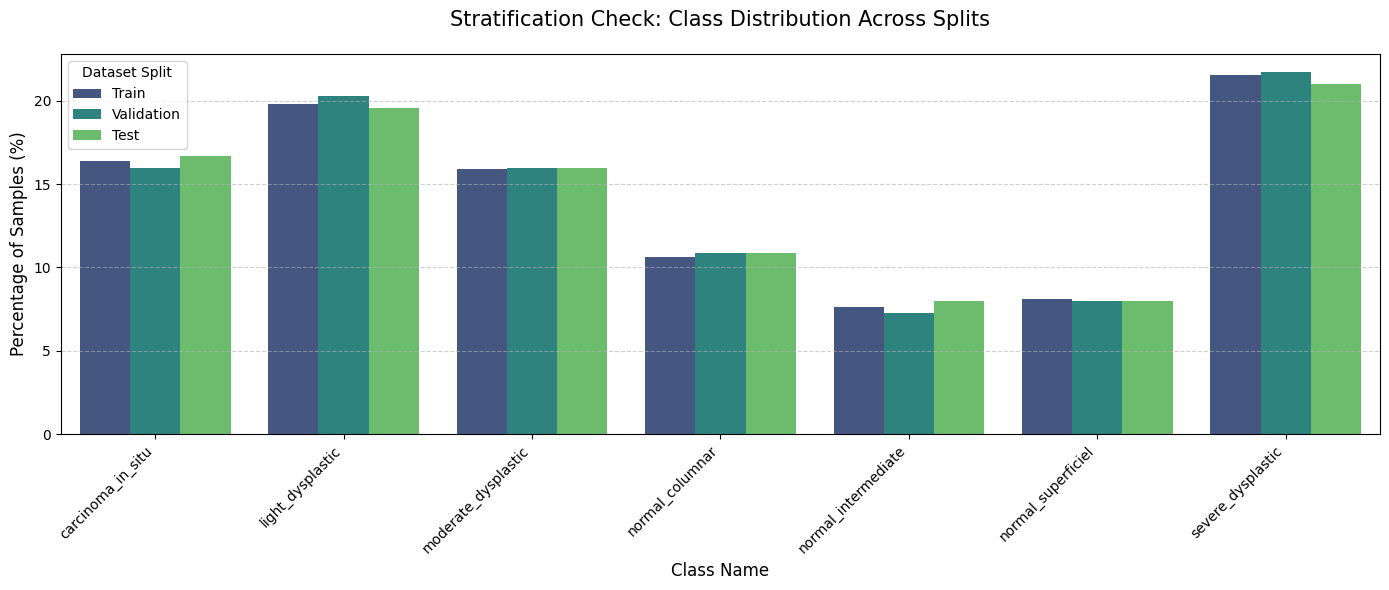

In [40]:
def plot_stratification(train_df, val_df, test_df, class_col='class_name'):
    # Calculate percentages for each set
    train_dist = train_df[class_col].value_counts(normalize=True).rename('Percentage').reset_index()
    train_dist['Split'] = 'Train'

    val_dist = val_df[class_col].value_counts(normalize=True).rename('Percentage').reset_index()
    val_dist['Split'] = 'Validation'

    test_dist = test_df[class_col].value_counts(normalize=True).rename('Percentage').reset_index()
    test_dist['Split'] = 'Test'

    # Combine data
    df_plot = pd.concat([train_dist, val_dist, test_dist])
    df_plot['Percentage'] *= 100 # Convert to %

    # Sort by Class Name for readability
    df_plot = df_plot.sort_values(by=class_col)

    # Plot
    plt.figure(figsize=(14, 6))
    sns.barplot(data=df_plot, x=class_col, y='Percentage', hue='Split', palette='viridis')

    plt.title('Stratification Check: Class Distribution Across Splits', fontsize=15, pad=20)
    plt.ylabel('Percentage of Samples (%)', fontsize=12)
    plt.xlabel('Class Name', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Dataset Split')
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# Run the function
plot_stratification(train, val, test)

#### CUSTOM PYTORCH DATASET

In [41]:
model_checkpoint = "google/vit-base-patch16-224"
processor = AutoImageProcessor.from_pretrained(model_checkpoint)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [42]:
# Define the Augmentation Pipeline
train_transforms = v2.Compose([
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.RandomRotation(degrees=45),
    v2.ColorJitter(brightness=0.1, contrast=0.1),
    # Note: ViT processor handles resizing and normalization later
])

In [43]:
class MultimodalCervicalDataset(Dataset):
    def __init__(self, dataframe, processor, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.processor = processor
        self.transform = transform # Apply only to training

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Load Image
        image = Image.open(row['image_path']).convert('RGB')

        # Apply Augmentation (if provided)
        if self.transform:
            image = self.transform(image)

        # ViT Processing (Resizing to 224x224, etc.)
        pixel_values = self.processor(image, return_tensors="pt").pixel_values.squeeze()

        # Tabular Features
        tabular_features = torch.tensor(row['features_normalized'], dtype=torch.float32)

        # Label
        label = torch.tensor(row['label_class'], dtype=torch.long)

        return {
            'pixel_values': pixel_values,
            'tabular_features': tabular_features,
            'labels': label,
            'image_id': row['image_id']
        }

In [44]:
# Create datasets datasets with augmentation on training only
train_dataset = MultimodalCervicalDataset(train, processor, transform=train_transforms)
val_dataset = MultimodalCervicalDataset(val, processor)
test_dataset = MultimodalCervicalDataset(test, processor)

print(f"✅ Datasets created")
print(f"   Samples:")
sample = train_dataset[0]
print(f"   - Image shape: {sample['pixel_values'].shape}")
print(f"   - Features tabular shape: {sample['tabular_features'].shape}")
print(f"   - Label: {sample['labels'].item()}")

✅ Datasets created
   Samples:
   - Image shape: torch.Size([3, 224, 224])
   - Features tabular shape: torch.Size([20])
   - Label: 4


#### CUSTOMIZED MULTIMODAL MODEL

In [45]:
class MultimodalCervicalClassifier(nn.Module):
    def __init__(self, vision_model_checkpoint, num_classes, num_tabular_features):
        super().__init__()

        # 1. Vision Branch (Pre-trained ViT)
        self.vision_model = AutoModel.from_pretrained(vision_model_checkpoint)
        vision_dim = self.vision_model.config.hidden_size  # 768

        # 2. Tabular Branch (Stronger MLP)
        self.tabular_mlp = nn.Sequential(
            nn.Linear(num_tabular_features, 128),
            nn.BatchNorm1d(128), # Normalizes the numbers for faster training
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 128),
            nn.ReLU()
        )
        tabular_dim = 128

        # 3. Fusion Layer (Bottleneck Architecture)
        # We add BatchNorm and use a deeper path to find correlations
        self.fusion = nn.Sequential(
            nn.Linear(vision_dim + tabular_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )

    def forward(self, pixel_values, tabular_features):
        # Vision features [batch, 768]
        vision_outputs = self.vision_model(pixel_values)
        vision_features = vision_outputs.pooler_output

        # Tabular features [batch, 128]
        tabular_features = self.tabular_mlp(tabular_features)

        # Concatenate and Classify
        combined = torch.cat([vision_features, tabular_features], dim=1)
        logits = self.fusion(combined)

        return logits

In [46]:
# Instantiate model
num_tabular_features = len(feature_columns)
model = MultimodalCervicalClassifier(
    vision_model_checkpoint=model_checkpoint,
    num_classes=len(class_names),
    num_tabular_features=num_tabular_features
)

print(f"✅ Multimodal model created")
print(f"   - Vision features: 768 (ViT-base)")
print(f"   - Tabular features: {num_tabular_features}")
print(f"   - Classes: {len(class_names)}")

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Multimodal model created
   - Vision features: 768 (ViT-base)
   - Tabular features: 20
   - Classes: 7


#### TRAINING AND EVALUATION FUNCTIONS

In [47]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [48]:
# Get the labels from the training set
y_train = train['label_class'].values

# Calculate weights: higher weight for classes with fewer samples
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Convert to a tensor for PyTorch
weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

print("✅ Computed Class Weights:")
for i, weight in enumerate(class_weights):
    print(f"   Class {i} ({id2label[i]}): {weight:.4f}")

✅ Computed Class Weights:
   Class 0 (carcinoma_in_situ): 0.8721
   Class 1 (light_dysplastic): 0.7210
   Class 2 (moderate_dysplastic): 0.8978
   Class 3 (normal_columnar): 1.3466
   Class 4 (normal_intermediate): 1.8688
   Class 5 (normal_superficiel): 1.7610
   Class 6 (severe_dysplastic): 0.6636


In [49]:
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.05)
scheduler = CosineAnnealingLR(optimizer, T_max=10)
# The weights_tensor tells the model to pay more attention to underrepresented classes
criterion = nn.CrossEntropyLoss(weight=weights_tensor)

In [50]:
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for batch in dataloader:
        pixel_values = batch['pixel_values'].to(device)
        tabular_features = batch['tabular_features'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        # Forward
        logits = model(pixel_values, tabular_features)
        loss = criterion(logits, labels)

        # Backward
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()

        # Metrics
        preds = logits.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)

    return avg_loss, accuracy

In [70]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            pixel_values = batch['pixel_values'].to(device)
            tabular_features = batch['tabular_features'].to(device)
            labels = batch['labels'].to(device)

            logits = model(pixel_values, tabular_features)
            loss = criterion(logits, labels)

            total_loss += loss.item()

            preds = logits.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    weighted_precision = precision_score(
        all_labels,
        all_preds,
        average='weighted',
        zero_division=0
    )

    return avg_loss, accuracy, f1, weighted_precision

##### TRAINING LOOP

In [52]:
# Define your save path
save_dir = '/content/drive/MyDrive/ML/Models/Herlev'

# Create the directory if it doesn't exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

VERSION = f"v1.0.0_{datetime.now().strftime("%Y%m%d")}"
MODEL_PATH = f"best_multimodal_model_{VERSION}.pth"

# Define the full path for the model
model_save_path = os.path.join(save_dir, MODEL_PATH)

In [53]:
print("\n" + "="*60)
print("STARTING TRAINING")
print("="*60)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

num_epochs = 50
best_val_accuracy = 0
patience = 10
patience_counter = 0

history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'val_f1': []
}

for epoch in range(num_epochs):
    # Train
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)

    # Validation
    val_loss, val_acc, val_f1 = evaluate(model, val_loader, criterion, device)

    scheduler.step()

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)

    print(f"Epoch {epoch+1:2d}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")

    # Early stopping
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), model_save_path)
        print(f"⭐️ New best model saved (Val Acc: {val_acc:.4f})")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping na epoch {epoch+1}")
            break

print("\n✅ Training completed!")


STARTING TRAINING
Epoch  1/50 | Train Loss: 1.8677 | Train Acc: 0.2750 | Val Loss: 1.8616 | Val Acc: 0.3261 | Val F1: 0.2469
⭐️ New best model saved (Val Acc: 0.3261)
Epoch  2/50 | Train Loss: 1.6559 | Train Acc: 0.4656 | Val Loss: 1.7014 | Val Acc: 0.3116 | Val F1: 0.2614
Epoch  3/50 | Train Loss: 1.4847 | Train Acc: 0.5328 | Val Loss: 1.5955 | Val Acc: 0.3116 | Val F1: 0.2574
Epoch  4/50 | Train Loss: 1.3475 | Train Acc: 0.6016 | Val Loss: 1.5091 | Val Acc: 0.4348 | Val F1: 0.3974
⭐️ New best model saved (Val Acc: 0.4348)
Epoch  5/50 | Train Loss: 1.2447 | Train Acc: 0.6281 | Val Loss: 1.4563 | Val Acc: 0.4493 | Val F1: 0.4212
⭐️ New best model saved (Val Acc: 0.4493)
Epoch  6/50 | Train Loss: 1.1755 | Train Acc: 0.6578 | Val Loss: 1.4106 | Val Acc: 0.4565 | Val F1: 0.4308
⭐️ New best model saved (Val Acc: 0.4565)
Epoch  7/50 | Train Loss: 1.1208 | Train Acc: 0.6813 | Val Loss: 1.3978 | Val Acc: 0.4565 | Val F1: 0.4125
Epoch  8/50 | Train Loss: 1.1029 | Train Acc: 0.6844 | Val Loss:

#### FINAL ASSESSMENT IN THE TEST SET

In [71]:
# Load best model
model.load_state_dict(torch.load(model_save_path))

test_loss, test_acc, test_f1, weighted_precision = evaluate(
    model, test_loader, criterion, device
)

print(f"   Test Loss: {test_loss:.4f}")
print(f"   Test Accuracy: {test_acc:.4f}")
print(f"   Test F1-Score: {test_f1:.4f}")
print(f"   Weighted Precision: {weighted_precision:.4f}")

   Test Loss: 0.9516
   Test Accuracy: 0.6594
   Test F1-Score: 0.6571
   Weighted Precision: 0.6558


In [55]:
# Generate Classification Report
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        pixel_values = batch['pixel_values'].to(device)
        tabular_features = batch['tabular_features'].to(device)
        labels = batch['labels'].to(device)

        logits = model(pixel_values, tabular_features)
        preds = logits.argmax(dim=1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

print("\n📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))


📊 Classification Report:
                     precision    recall  f1-score   support

  carcinoma_in_situ       0.74      0.74      0.74        23
   light_dysplastic       0.65      0.63      0.64        27
moderate_dysplastic       0.38      0.36      0.37        22
    normal_columnar       0.80      0.80      0.80        15
normal_intermediate       0.82      0.82      0.82        11
 normal_superficiel       0.77      0.91      0.83        11
  severe_dysplastic       0.62      0.62      0.62        29

           accuracy                           0.66       138
          macro avg       0.68      0.70      0.69       138
       weighted avg       0.66      0.66      0.66       138




✅ Confusion matrix saved!


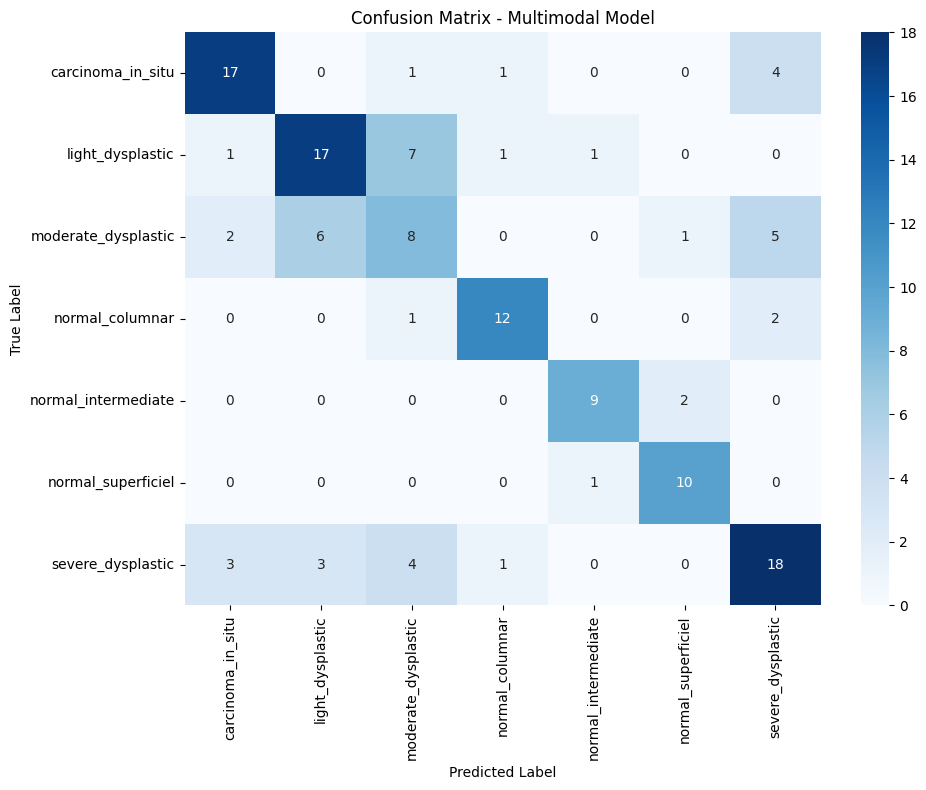

In [56]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Multimodal Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'confusion_matrix.png'))
print("\n✅ Confusion matrix saved!")
plt.show()

In [57]:
def visualize_misclassified(model, dataloader, class_names, device, num_images=8):
    model.eval()
    misclassified = []

    print("Searching for misclassified images...")
    with torch.no_grad():
        for batch in dataloader:
            pixel_values = batch['pixel_values'].to(device)
            tabular_features = batch['tabular_features'].to(device)
            labels = batch['labels'].to(device)
            image_ids = batch['image_id']

            logits = model(pixel_values, tabular_features)
            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)

            # Find indices where prediction != label
            wrong_idx = (preds != labels).nonzero(as_tuple=True)[0]

            for idx in wrong_idx:
                # We need to find the original image path from the dataframe
                # Since the test_loader isn't shuffled, we can use the image_id
                img_id = image_ids[idx]
                img_path = test[test['image_id'] == img_id]['image_path'].values[0]

                misclassified.append({
                    'path': img_path,
                    'true': class_names[labels[idx].item()],
                    'pred': class_names[preds[idx].item()],
                    'conf': probs[idx][preds[idx]].item(),
                    'id': img_id
                })

    # Sort by confidence (highest first) to see where the model was "sure but wrong"
    misclassified = sorted(misclassified, key=lambda x: x['conf'], reverse=True)

    # Plotting
    rows = (num_images + 3) // 4
    plt.figure(figsize=(20, 5 * rows))

    for i, m in enumerate(misclassified[:num_images]):
        plt.subplot(rows, 4, i + 1)
        img = Image.open(m['path'])
        plt.imshow(img)
        plt.title(f"True: {m['true']}\nPred: {m['pred']}\nConf: {m['conf']:.2f}",
                  color='red', fontsize=12)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

Searching for misclassified images...


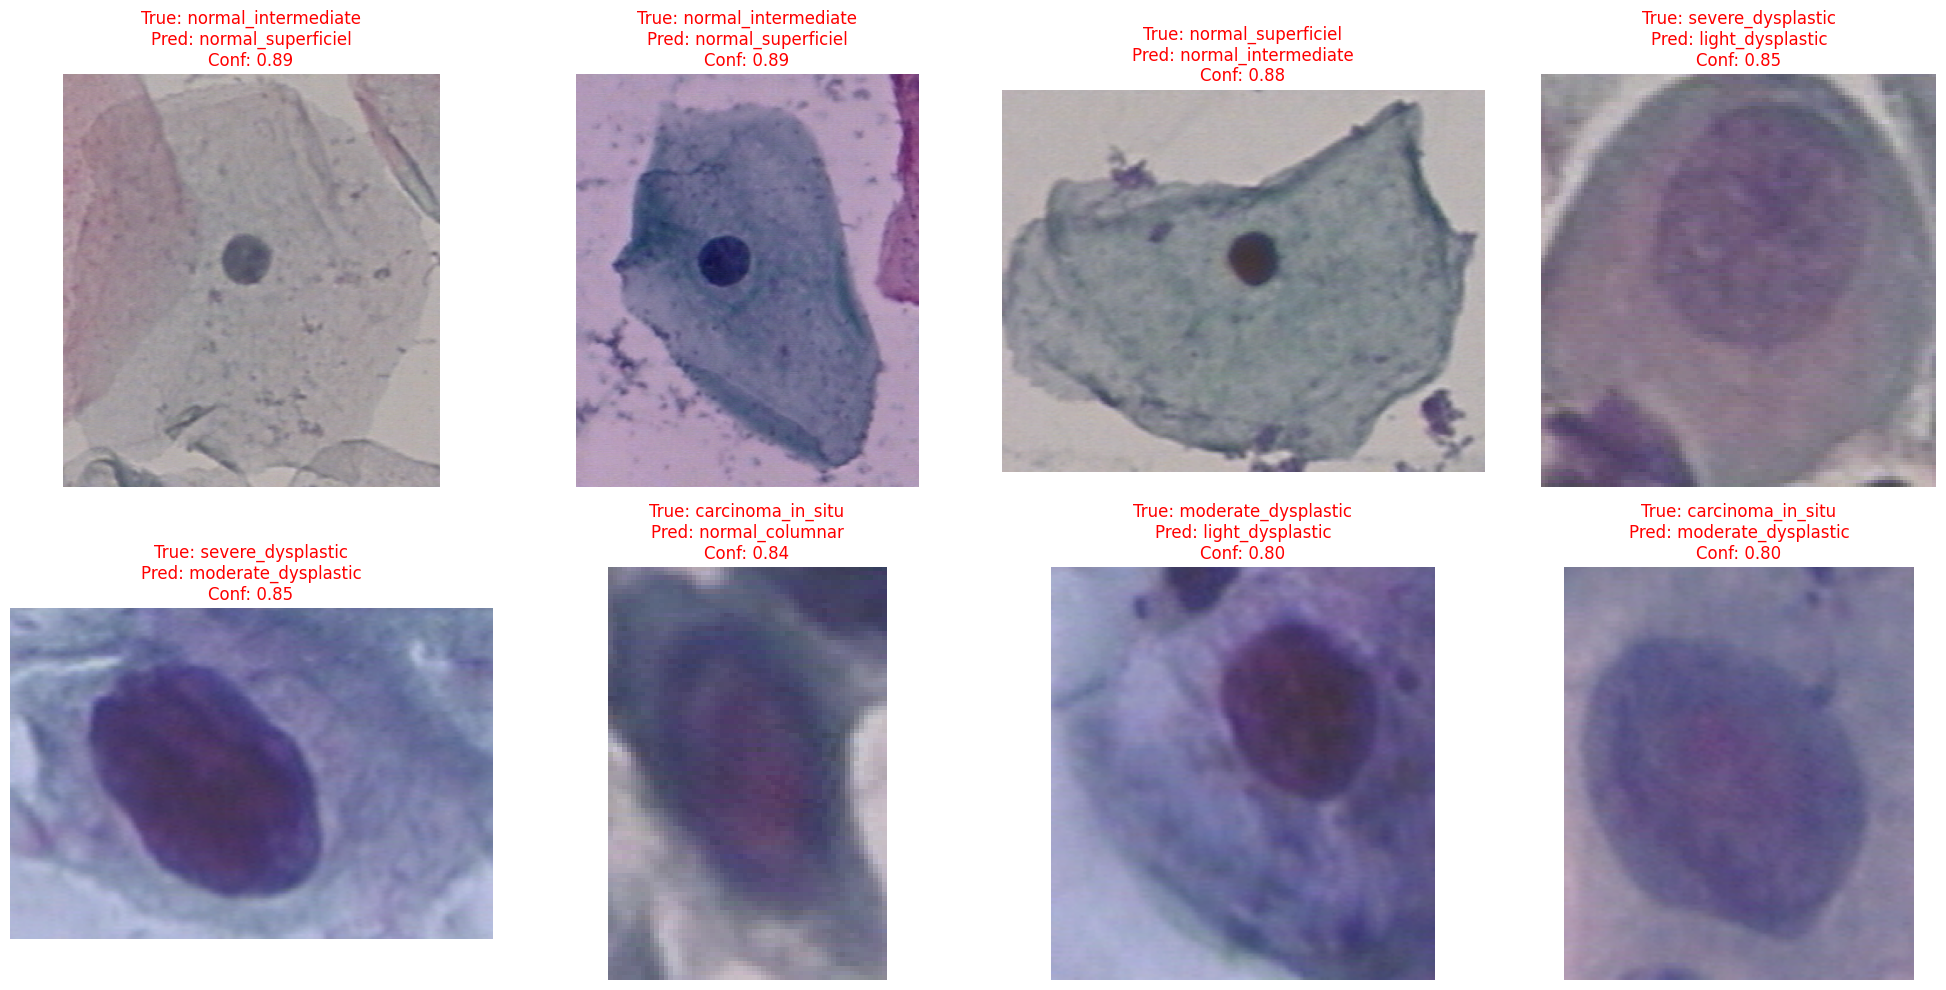

In [58]:
# Run the visualization
visualize_misclassified(model, test_loader, class_names, device)

#### SAVE FOR PRODUCTION

In [59]:
print("\n" + "="*60)
print("SAVING MODEL FOR PRODUCTION")
print("="*60)

# Save Weights
torch.save({
    'model_state_dict': model.state_dict(),
    'scaler_mean': scaler.mean_,
    'scaler_scale': scaler.scale_,
    'feature_names': feature_columns,
    'class_names': class_names,
    'num_tabular_features': num_tabular_features
}, os.path.join(save_dir, f"final_multimodal_model_{VERSION}.pt"))


print("✅ Model saved as ", os.path.join(save_dir, f"final_multimodal_model_{VERSION}.pt"))


SAVING MODEL FOR PRODUCTION
✅ Model saved as  /content/drive/MyDrive/ML/Models/Herlev/final_multimodal_model_v1.0.0_20251218.pt


#### INFERENCE FUNCTION

In [65]:
def predict_multimodal(image_path, tabular_features_dict, model, processor, scaler, device):
    """
    Making predictions with the multimodal model

      Args:
        image_path: image path
        tabular_features_dict: dict with tabular features {feature_name: value}
        model: trained model
        processor: image processor
        scaler: StandardScaler to normalize features
        device: 'cuda' or 'cpu'
    """
    model.eval()

    # Image processing
    image = Image.open(image_path).convert('RGB')
    pixel_values = processor(image, return_tensors="pt").pixel_values.to(device)

    # Process tabular features
    tabular_array = np.array([tabular_features_dict[name] for name in feature_columns]).reshape(1, -1)
    tabular_normalized = scaler.transform(tabular_array)
    tabular_features = torch.tensor(tabular_normalized, dtype=torch.float32).to(device)

    with torch.no_grad():
        logits = model(pixel_values, tabular_features)
        probabilities = torch.softmax(logits, dim=1).cpu().numpy()[0]

    predictions = {class_names[i]: probabilities[i] for i in range(len(class_names))}

    return predictions

In [66]:
print("✅ Inference function created!")
print("\nExample of use:")
print("""
        predictions = predict_multimodal(
        image_path='path/to/image.BMP',
        tabular_features_dict={
        'Kerne_A': 803.5,

        'Cyto_A': 27804.125,

        # ... other features

        },
        model=model,
        processor=processor,
        scaler=scaler,
        device=device
        )
        print(predictions)
      """
)

print("\n" + "="*60)
print("🎉 MULTIMODAL PROJECT SUCCESSFULLY COMPLETED!")
print("="*60)

✅ Inference function created!

Example of use:

        predictions = predict_multimodal(
        image_path='path/to/image.BMP',
        tabular_features_dict={
        'Kerne_A': 803.5,

        'Cyto_A': 27804.125,

        # ... other features

        },
        model=model,
        processor=processor,
        scaler=scaler,
        device=device
        )
        print(predictions)
      

🎉 MULTIMODAL PROJECT SUCCESSFULLY COMPLETED!


In [62]:
def run_ablation_study(model, dataloader, device, class_names):
    model.eval()
    results = {}

    # 1. Full Multimodal (Baseline)
    _, acc_full, f1_full = evaluate(model, dataloader, criterion, device)
    results['Multimodal (Both)'] = acc_full

    # 2. Vision Only (Zero out Tabular)
    all_preds_v = []
    all_labels = []
    with torch.no_grad():
        for batch in dataloader:
            pixel_values = batch['pixel_values'].to(device)
            # Create a zero-tensor of the same shape as tabular features
            zero_tab = torch.zeros_like(batch['tabular_features']).to(device)
            labels = batch['labels']

            logits = model(pixel_values, zero_tab)
            all_preds_v.extend(logits.argmax(dim=1).cpu().numpy())
            all_labels.extend(labels.numpy())

    acc_v = (np.array(all_preds_v) == np.array(all_labels)).mean()
    results['Vision Only'] = acc_v

    # 3. Tabular Only (Zero out Images)
    all_preds_t = []
    with torch.no_grad():
        for batch in dataloader:
            # Create a zero-tensor of the same shape as pixel values (usually [B, 3, 224, 224])
            zero_img = torch.zeros_like(batch['pixel_values']).to(device)
            tabular_features = batch['tabular_features'].to(device)

            logits = model(zero_img, tabular_features)
            all_preds_t.extend(logits.argmax(dim=1).cpu().numpy())

    acc_t = (np.array(all_preds_t) == np.array(all_labels)).mean()
    results['Tabular Only'] = acc_t

    return results

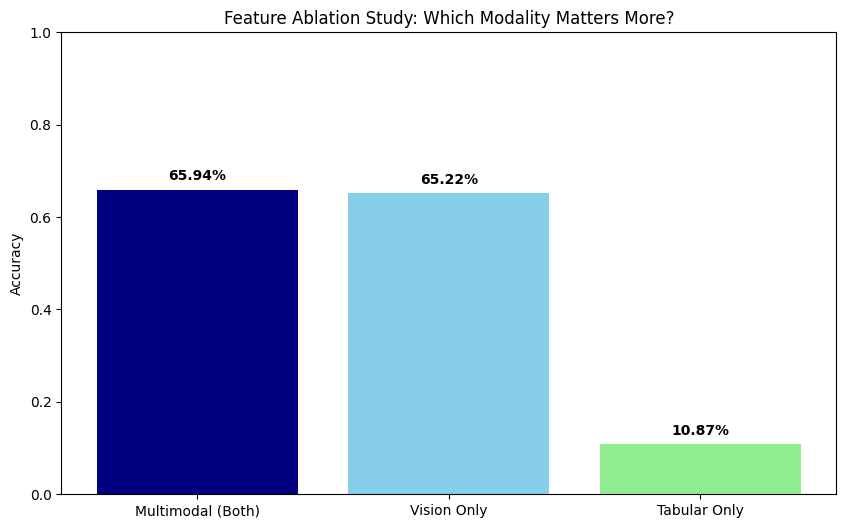

In [63]:
# Run and Plot
ablation_results = run_ablation_study(model, test_loader, device, class_names)

plt.figure(figsize=(10, 6))
plt.bar(ablation_results.keys(), ablation_results.values(), color=['navy', 'skyblue', 'lightgreen'])
plt.ylabel('Accuracy')
plt.title('Feature Ablation Study: Which Modality Matters More?')
plt.ylim(0, 1.0)
for i, v in enumerate(ablation_results.values()):
    plt.text(i, v + 0.02, f"{v:.2%}", ha='center', fontweight='bold')
plt.show()

Checking for Data Health...
Total NaN values: 0
Constant columns: []

📊 Top Features by Statistical Significance (p < 0.05 is good):
    Feature        p-value
1    feat_1  1.505408e-293
9    feat_9  3.256000e-288
18  feat_18  2.089353e-263
19  feat_19  9.956242e-256
2    feat_2  7.306064e-248
14  feat_14  2.336866e-247
10  feat_10  3.005723e-228
13  feat_13  3.956279e-150
6    feat_6  1.077517e-148
12  feat_12  3.423788e-148


/tmp/ipython-input-1231813301.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=class_col, y=feat, ax=axes[i], palette='viridis')
/tmp/ipython-input-1231813301.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(class_names, rotation=45, ha='right')
/tmp/ipython-input-1231813301.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=class_col, y=feat, ax=axes[i], palette='viridis')
/tmp/ipython-input-1231813301.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xt

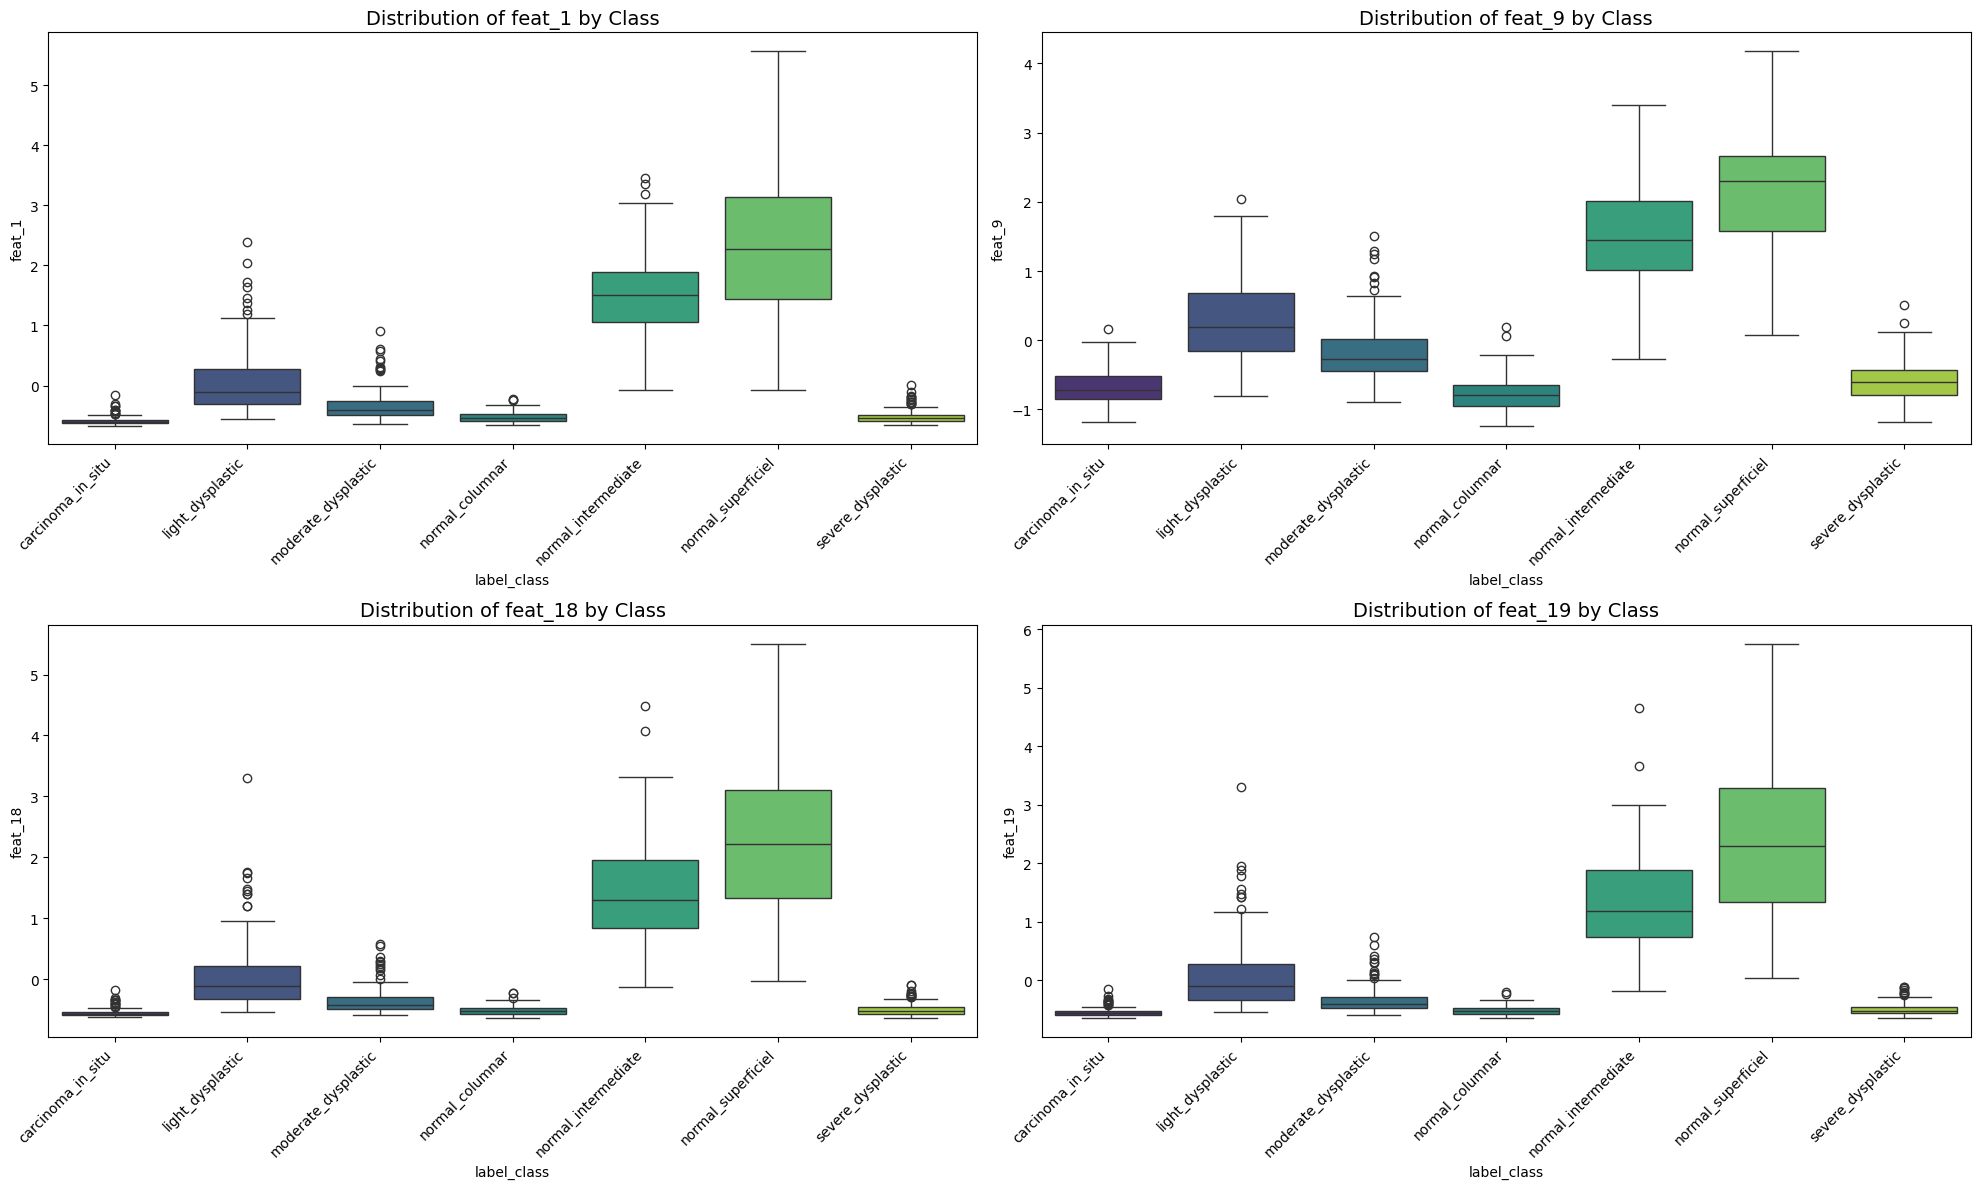

In [64]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_classif

def analyze_tabular_features(df, feature_names, class_col='label_class'):
    # 1. Check for basic data health
    print("Checking for Data Health...")
    print(f"Total NaN values: {df[feature_names].isna().sum().sum()}")
    print(f"Constant columns: {[col for col in feature_names if df[col].nunique() <= 1]}")

    # 2. Statistical Significance (ANOVA)
    # This tells us if a feature is mathematically useful
    f_stat, p_values = f_classif(df[feature_names], df[class_col])
    importance_df = pd.DataFrame({'Feature': feature_names, 'p-value': p_values}).sort_values('p-value')

    print("\n📊 Top Features by Statistical Significance (p < 0.05 is good):")
    print(importance_df.head(10))

    # 3. Visualization: The "Boxplot Test"
    # We pick the top 4 most significant features to visualize
    top_features = importance_df['Feature'].head(4).tolist()

    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    axes = axes.flatten()

    for i, feat in enumerate(top_features):
        sns.boxplot(data=df, x=class_col, y=feat, ax=axes[i], palette='viridis')
        axes[i].set_title(f'Distribution of {feat} by Class', fontsize=14)
        axes[i].set_xticklabels(class_names, rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

# NOTE: If your features are inside the 'features_normalized' list,
# you need to expand them first:
feature_cols = [f'feat_{i}' for i in range(len(df_multimodal['features_normalized'].iloc[0]))]
df_analysis = pd.concat([df_multimodal, pd.DataFrame(df_multimodal['features_normalized'].tolist(), columns=feature_cols)], axis=1)
analyze_tabular_features(df_analysis, feature_cols)

#### DEPLOY TO HUGGING FACE

In [92]:
# Login on Hugging Face (requires a token, have it in settings -> Access Tokens)
notebook_login()

In [93]:
# CREATE REPOSITORY IN THE HUB
repo_name = "cervical-cancer-multimodal-vit"
repo_id = f"sastelvio/{repo_name}"

api = HfApi()

# Create repository (if it doesn't exist)
try:
    create_repo(repo_id, repo_type="model", exist_ok=True)
    print(f"✅ Repository created/verified: {repo_id}")
except:
    print(f"⚠️  The repository already exist.")

✅ Repository created/verified: sastelvio/cervical-cancer-multimodal-vit


In [102]:
# CREATE MODEL CARD (README.md)
model_card = f"""---
language:
  - en
license: mit
datasets:
  - smear2005
tags:
  - medical-imaging
  - multimodal
  - vision-transformer
  - cervical-cancer
  - histopathology
---

# Cervical Cancer Multimodal Classifier

## Model Description

This is an advanced **multimodal** model that classifies cervical cancer using both:
- **Visual features** from histopathological images (Vision Transformer)
- **Morphological features** from tabular data (20 hand-crafted features)

### Model Architecture

```
┌──────────────────┐         ┌────────────────────┐
│  Histopath.     │         │ Tabular Features │
│   Image (BMP)   │         │   (20 features)  │
└────────┬─────────┘         └────────┬───────────┘
         │                           │
         │                           │
         ▼                           ▼
   ┌───────────────┐           ┌─────────────┐
   │  ViT-base    │           │  MLP       │
   │  (768 dims)  │           │  (64 dims) │
   └──────┬────────┘           └────┬────────┘
          │                        │
          └────────┬───────────────┘
                   │
                   ▼
            ┌──────────────────┐
            │  Fusion Layer   │
            │  (512 -> 256)   │
            └────────┬─────────┘
                     │
                     ▼
            ┌──────────────────┐
            │  Output (7)     │
            │  Classes        │
            └──────────────────┘
```

## Supported Classes

1. **carcinoma_in_situ** - Carcinoma in situ
2. **light_dysplastic** - Light dysplastic
3. **moderate_dysplastic** - Moderate dysplastic
4. **normal_columnar** - Normal columnar
5. **normal_intermediate** - Normal intermediate
6. **normal_superficiel** - Normal superficial
7. **severe_dysplastic** - Severe dysplastic

## Performance

|          Metric        |           Value          |
|------------------------|--------------------------|
|   **Test Accuracy**    |      {test_acc:.4f}      |
|   **Test F1-Score**    |      {test_f1:.4f}       |
| **Weighted Precision** | {weighted_precision:.4f} |

## Training Details

- **Dataset**: Smear2005 (Herlev Colposcopy) [https://mde-lab.aegean.gr/index.php/downloads/]
- **Vision Backbone**: google/vit-base-patch16-224
- **Training Epochs**: {num_epochs} (with early stopping at {patience})
- **Batch Size**: {batch_size}
- **Learning Rate**: 2e-5 (AdamW)
- **Scheduler**: CosineAnnealingLR
- **Hardware**: NVIDIA T4 GPU on Google Colab

num_epochs = {num_epochs}
best_val_accuracy = {best_val_accuracy}
patience = {patience}
patience_counter = {patience_counter}

## Tabular Features

The model uses 20 morphological features extracted from nuclei analysis:

- **Nucleus Area**: Kerne_A
- **Cytoplasm Area**: Cyto_A
- **Nucleus-Cytoplasm Ratio**: K/C
- **Y-coordinates**: Kerne_Ycol, Cyto_Ycol
- **Morphological indices**: KerneShort, KerneLong, KerneElong, KerneRund
- **Perimeter**: KernePeri, CytoPeri
- **Size ratios**: KerneMax, KerneMin, CytoMax, CytoMin
- **Position**: KernePos

Features are **StandardScaler normalized** using training set statistics.

## Usage

### Installation

```bash
pip install torch transformers pillow scikit-learn
```

### Quick Start

```python
import torch
from PIL import Image
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load model
model = torch.load('multimodal_cervical_model.pt')

# Your image and tabular data
image = Image.open('sample.BMP')
tabular_features = {{
    'Kerne_A': 803.5,
    'Cyto_A': 27804.125,
    # ... 18 more features
}}

# Predict
predictions = predict_multimodal(image, tabular_features, ...)
```

## Advantages

✅ **Multimodal Fusion**: Combines spatial-visual features with quantitative morphological data
✅ **Robustness**: Less prone to overfitting than single-modality models
✅ **Interpretability**: Features are human-interpretable (sizes, ratios, etc.)
✅ **Scalability**: Can add more modalities (ultrasound, genetic data, etc.)

## Limitations

⚠️ Limited to 7 classes (specific dataset)
⚠️ Requires both image and tabular data for inference
⚠️ Image input must be histopathological cervical samples

## Citation

If you use this model, please cite:

```bibtex
@misc{{cervical_multimodal_2025,
  title = {{Cervical Cancer Multimodal Classifier}},
  author = {{Sastelvio MANUEL}},
  year = {datetime.now().year},
  howpublished = {{\\url{{https://huggingface.co/sastelvio/cervical-cancer-multimodal-vit}}}}
}}
```

## Disclaimer

⚠️ **Medical Use Only Under Professional Supervision**

This model is for research and educational purposes. It should **NOT** be used for clinical diagnosis without:
- Validation by medical professionals
- Proper regulatory approval
- Thorough clinical testing
- Integration with clinical workflows

## Author

[Sastelvio MANUEL]
Portfolio: [https://github.com/sastelvio]

## License

MIT License - See LICENSE file for details

---

*Last updated:  {datetime.now().strftime("%d %B %Y")}*
"""

In [103]:
# Save README
with open(os.path.join(save_dir, 'README.md'), 'w', encoding='utf-8') as f:
    f.write(model_card)

print("✅ README.md created!")

✅ README.md created!


In [89]:
# CREATE CONFIGURATION FILE

config_dict = {
    "model_type": "multimodal",
    "vision_backbone": "google/vit-base-patch16-224",
    "num_classes": 7,
    "num_tabular_features": 20,
    "class_labels": {
        0: "carcinoma_in_situ",
        1: "light_dysplastic",
        2: "moderate_dysplastic",
        3: "normal_columnar",
        4: "normal_intermediate",
        5: "normal_superficiel",
        6: "severe_dysplastic"
    },
    "feature_columns": [
        "Kerne_A", "Cyto_A", "K/C", "Kerne_Ycol", "Cyto_Ycol",
        "KerneShort", "KerneLong", "KerneElong", "KerneRund",
        "CytoShort", "CytoLong", "CytoElong", "CytoRund",
        "KernePeri", "CytoPeri", "KernePos", "KerneMax",
        "KerneMin", "CytoMax", "CytoMin"
    ],
    "training_config": {
        "batch_size": 16,
        "learning_rate": 2e-5,
        "num_epochs": 50,
        "optimizer": "AdamW",
        "scheduler": "CosineAnnealingLR",
        "early_stopping_patience": 10
    }
}

with open(os.path.join(save_dir, 'config.json'), 'w') as f:
    json.dump(config_dict, f, indent=2)

print("✅ config.json created!")

✅ config.json created!


In [90]:
import pkg_resources

packages = [
    "torch",
    "transformers",
    "huggingface_hub",
    "datasets",
    "accelerate",
    "evaluate",
    "pillow",
    "numpy",
    "pandas",
    "scikit-learn",
    "openpyxl",
    "matplotlib",
    "seaborn",
    "wandb"
]

requirements = []
for pkg in packages:
    try:
        version = pkg_resources.get_distribution(pkg).version
        requirements.append(f"{pkg}=={version}")
    except Exception:
        requirements.append(pkg)

with open(os.path.join(save_dir, "requirements.txt"), "w") as f:
    f.write("\n".join(requirements))
print("✅ requirements.txt created!")

✅ requirements.txt created!


In [104]:
# UPLOAD TO HUGGING FACE
api.upload_folder(
    folder_path=save_dir,
    repo_id=repo_id,
    repo_type="model",
    commit_message="Upload multimodal cervical cancer classifier"
)

print(f"\n✅ Model send to: https://huggingface.co/{repo_id}")

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ..._model_v1.0.0_20251218.pt:   2%|2         | 8.31MB /  347MB            


✅ Model send to: https://huggingface.co/sastelvio/cervical-cancer-multimodal-vit


In [95]:
# CREATE SPACE FOR INFERENCE (GRADIO)
space_code = '''
import gradio as gr
import torch
import numpy as np
from PIL import Image
from sklearn.preprocessing import StandardScaler
from transformers import AutoImageProcessor
import json

# Load configuration
with open('config.json') as f:
    config = json.load(f)

# Expected features
feature_names = config['feature_columns']
class_names = list(config['class_labels'].values())

# Interface Gradio
with gr.Blocks(title="Cervical Cancer Multimodal Classifier") as demo:
    gr.Markdown("""
    # 🔬 Cervical Cancer Multimodal Classifier

    This model classifies cervical cell samples using both **histopathological images**
    and **morphological features**.

    Provide both inputs for best results!
    """)

    with gr.Row():
        with gr.Column():
            gr.Markdown("### Input Image")
            image_input = gr.Image(label="Histopathological Image", type="pil")

        with gr.Column():
            gr.Markdown("### Morphological Features")
            feature_inputs = []
            for fname in feature_names[:10]:
                feature_inputs.append(
                    gr.Number(label=fname, value=0.0)
                )
            gr.Markdown("### More Features")
            feature_inputs2 = []
            for fname in feature_names[10:]:
                feature_inputs2.append(
                    gr.Number(label=fname, value=0.0)
                )

    submit_btn = gr.Button("🔍 Classify", variant="primary", size="lg")

    with gr.Row():
        output_label = gr.Label(label="Prediction", num_top_classes=7)
        output_plot = gr.Plot(label="Confidence Distribution")

    # Callback funtion (simplified)
    def classify(image, *features):
        # Load model from Hub
        # Make prediction
        # Return results
        return "normal_superficiel", None

    submit_btn.click(
        classify,
        inputs=[image_input] + feature_inputs + feature_inputs2,
        outputs=[output_label, output_plot]
    )

    gr.Examples(
        examples=[
            ["sample1.BMP", 803.5, 27804.125, 0.028, 85.86, 192.52] + [0]*15,
            ["sample2.BMP", 610.1, 18067.8, 0.032, 81.53, 153.43] + [0]*15,
        ],
        inputs=[image_input] + feature_inputs + feature_inputs2,
        label="Example Inputs"
    )

if __name__ == "__main__":
    demo.launch()
'''

with open('app.py', 'w') as f:
    f.write(space_code)

print("✅ app.py (Gradio) created!")

print("\n" + "="*60)
print("🎉 DEPLOY COMPLETED!")
print("="*60)
print(f"\nModel is in: https://huggingface.co/{repo_id}")
print(f"Create a Space in: https://huggingface.co/spaces/new")
print("  - Select your repository.")
print("  - Use app.py as the main file.")

✅ app.py (Gradio) created!

🎉 DEPLOY COMPLETED!

Model is in: https://huggingface.co/sastelvio/cervical-cancer-multimodal-vit
Create a Space in: https://huggingface.co/spaces/new
  - Select your repository.
  - Use app.py as the main file.
